In [1]:
'''
In this example, we build a binary MNIST classifier and then run GeoCert on several test points.
'''

# =====================
# Imports
# =====================
%load_ext line_profiler
import sys
sys.path.append('..')
sys.path.append('../mister_ed') # library for adversarial examples

import geocert_oop as geo
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face
import utilities as utils
import os
import time 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms


import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import mnist.mnist_loader as  ml 
mnist_trainset = ml.load_mnist_data('train')
mnist_valset = ml.load_mnist_data('val')


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [2]:
# Code to select only a subset of digits from MNIST datasets
def select_digits(dataset, digits, mb_size=128, remap_label=True):
    if remap_label and len(digits) <= 2:
        def label_map(labels):
            return (labels == digits[0]).unsqueeze(1)
    elif remap_label and len(digits) > 2:
        raise NotImplementedError("Only handling between 2 types of digits for now")
    else:
        label_map = lambda x: x
            
    sel_data, sel_labels = [], [] 
    for data, labels in dataset:
        mask = labels == -1
        for digit in digits:
            mask += (labels == digit)
        #mask = (labels == 7) + (labels == 1)
        masked_data = data.masked_select(mask.view(-1, 1, 1, 1).expand(data.shape)).view(-1, 1, 28, 28)
        masked_labels = labels.masked_select(mask)
        sel_data.append(masked_data)
        sel_labels.append(masked_labels)
        
    # Then concatenate and resplit into minibatches of size 128
    cat_data = torch.cat(sel_data)
    cat_labels = torch.cat(sel_labels)
    full_dataset = [] 
    num_mb = int(len(cat_labels) / mb_size + 1)
    for i in range(num_mb):
        full_dataset.append((cat_data[mb_size * i: mb_size * (i + 1)], 
                             label_map(cat_labels[mb_size * i: mb_size * (i + 1)]).squeeze().long()))
    return full_dataset



In [3]:
# Make a dataset containing only 1's and 7's
MINIBATCH_SIZE = 128
os_trainset = select_digits(mnist_trainset, [1, 7], mb_size=MINIBATCH_SIZE)
os_valset = select_digits(mnist_valset, [1, 7], mb_size=MINIBATCH_SIZE)



In [4]:
# Define functions to train and evaluate a network 

def l1_loss(net):
    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

def train(net, trainset, num_epochs):
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        err_acc = 0
        err_count = 0
        for data, labels in trainset:
            output = net(Variable(data.view(-1, 784)))
            l = nn.CrossEntropyLoss()(output, Variable(labels)).view([1])
            l1_scale = torch.Tensor([2e-3])
            l += l1_scale * l1_loss(net).view([1])
            
            err_acc += (output.max(1)[1].data != labels).float().mean() 
            err_count += 1
            opt.zero_grad() 
            (l).backward() 
            opt.step() 
        print("(%02d) error:" % epoch, err_acc / err_count)
            
        
def test_acc(net, valset):
    err_acc = 0 
    err_count = 0 
    for data, labels in valset:
        n = data.shape[0]
        output = net(Variable(data.view(-1, 784)))
        err_acc += (output.max(1)[1].data != labels).float().mean() * n
        err_count += n
        
    print("Accuracy of: %.03f" % (1 - (err_acc / err_count).item()))



In [5]:
# Define the network architecture.
MNIST_DIM = 784
network = PLNN([MNIST_DIM, 10, 50, 10, 2])
net = network.net

# Train and evaluate the network 
train(net, os_trainset, 10)
test_acc(net, os_valset)


[784, 10, 50, 10, 2]
(00) error: tensor(0.1870)
(01) error: tensor(0.0118)
(02) error: tensor(0.0098)
(03) error: tensor(0.0088)
(04) error: tensor(0.0078)
(05) error: tensor(0.0070)
(06) error: tensor(0.0067)
(07) error: tensor(0.0065)
(08) error: tensor(0.0062)
(09) error: tensor(0.0062)
Accuracy of: 0.990


torch.Size([1, 28, 28])


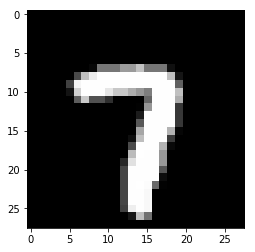

In [6]:
# With a trained net, we can pick some examples and run GeoCert on them 
EXAMPLE_NUMBER = 8
data, labels = next(iter(os_valset)) # select a minibatch of the validation set
example = data[EXAMPLE_NUMBER]
print(example.shape)
plt.gray()
plt.imshow(example.squeeze())

Starting CW Upper Bound
CWL2 failed to find an upper bound
---Initial Polytope---
Num facets:  23
REJECT DICT:  {'infeasible': 47}
23
---Opening New Polytope---
Bounds  0.17022234071007494   |   None
Num facets:  19
REJECT DICT:  {'infeasible': 50, 'seen before': 1}
---Opening New Polytope---
Bounds  0.49751731238932956   |   None
Num facets:  16
REJECT DICT:  {'infeasible': 53, 'seen before': 1}
---Opening New Polytope---
Bounds  0.764817109635853   |   None
Num facets:  17
REJECT DICT:  {'infeasible': 52, 'seen before': 1}
---Opening New Polytope---
Bounds  0.8214995016653449   |   None
Num facets:  18
REJECT DICT:  {'infeasible': 51, 'seen before': 1}
---Opening New Polytope---
Bounds  0.907943251611742   |   None
Num facets:  15
REJECT DICT:  {'infeasible': 54, 'seen before': 1}
---Opening New Polytope---
Bounds  1.2048419617657802   |   295972.63889083755
Num facets:  22
REJECT DICT:  {'infeasible': 47, 'seen before': 1}
---Opening New Polytope---
Bounds  1.2668733809184138   |   

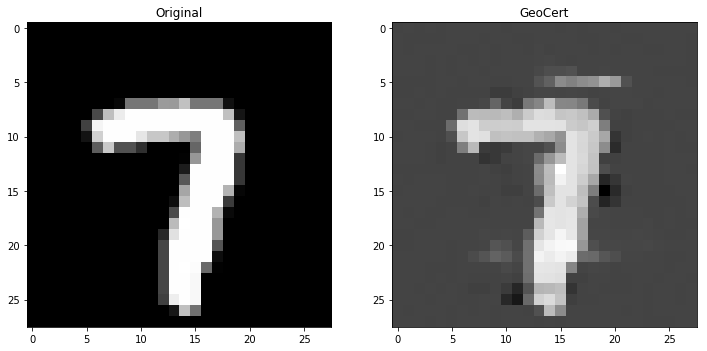

In [8]:
from importlib import reload 
reload(geo)
# Builds an object used to to hold algorithm parameters
geocert = geo.IncrementalGeoCert(network, verbose=True, config_fxn='parallel', 
                                 config_fxn_kwargs={'num_jobs': 1})

# Runs the algorithm
start = time.time()
lp_dist, cw_bound, cw_example, adver_example, boundary = geocert.min_dist(example.view(1, -1), lp_norm='l_2', 
                                                                          compute_upper_bound=True)
end = time.time() 

# Prints outputs
print("Found an adversarial example at dist", lp_dist, " in %.02f seconds " % (end - start))
if cw_bound is not None:
    print("Carlini-Wagner attack found example at distance", cw_bound)
original_logits = network(example)
adver_logits = network(torch.Tensor(adver_example).view(1, 28, 28))
print("Original output was ", original_logits.data.cpu().numpy())
print("Adversarial output was ", adver_logits.data.cpu().numpy())

# Display the adversarial examples 
to_displays = [(example.cpu().numpy().reshape((28, 28)), 'Original'), 
               (adver_example.reshape((28, 28)), 'GeoCert')]
if cw_example is not None: 
    to_displays.append((cw_out.reshape((28, 28)), 'Carlini-Wagner L2'))
f, axarr = plt.subplots(1, len(to_displays), figsize=(12, 12))
for i in range(len(to_displays)):
    axarr[i].imshow(to_displays[i][0])
    axarr[i].set_title(to_displays[i][1])


In [7]:
import geo_attack
geo_crawl = geo_attack.NaiveGeoCrawl(network)
x = example.view(1, -1)
label = torch.max(network(x).squeeze(), dim=0)[1]
output = geo_crawl.attack(example.view(1, -1), label)

--------------------------------------------------
ITERATION 00
LOSS: -7.567688941955566
--------------------------------------------------
--------------------------------------------------
ITERATION 01
LOSS: -6.41751766204834
--------------------------------------------------
--------------------------------------------------
ITERATION 02
LOSS: -6.115481376647949
--------------------------------------------------
--------------------------------------------------
ITERATION 03
LOSS: -5.376339912414551
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -5.1055402755737305
--------------------------------------------------
--------------------------------------------------
ITERATION 05
LOSS: 6.661563396453857
--------------------------------------------------


tensor([[ 4.5200, -3.4052]], grad_fn=<ThAddmmBackward>) tensor([[0.0720, 0.0720]], grad_fn=<ThAddmmBackward>)
2.597477


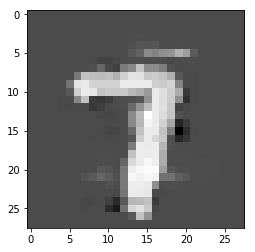

In [9]:
print(network(x), network(output))
print(np.linalg.norm(output.data - x.data))


plt.imshow(output.data.view(28, 28).numpy())


In [11]:
gcs = []
data, labels = next(iter(os_valset)) # select a minibatch of the validation set
for i in range(128):
    datum, label = data[i], labels[i]
    try:
        gcs.append((datum, geo_crawl.attack(datum.view(1, -1), label)))
    except:
        pass

--------------------------------------------------
ITERATION 00
LOSS: 3.9385833740234375
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -5.158719062805176
--------------------------------------------------
-1.1920929e-07
--------------------------------------------------
ITERATION 01
LOSS: 3.9612233638763428
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -4.891084671020508
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 01
LOSS: 3.755350112915039
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -7.7725324630737305
--------------------------------------------------
--------------------------------------------------
ITERATION 01
LOSS: -6.371041297912598
-----------------------------------------

-1.4901161e-08
--------------------------------------------------
ITERATION 03
LOSS: -5.37646484375
--------------------------------------------------
-8.940697e-08
--------------------------------------------------
ITERATION 04
LOSS: -5.362675666809082
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 05
LOSS: -4.924435615539551
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 06
LOSS: 3.7813808917999268
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -4.561079502105713
--------------------------------------------------
--------------------------------------------------
ITERATION 01
LOSS: -4.438205718994141
--------------------------------------------------
-2.3841858e-07
--------------------------------------------------
ITERATION 02
LOSS: -4.162818908691406
-

--------------------------------------------------
ITERATION 02
LOSS: -5.102490425109863
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 03
LOSS: -4.639159202575684
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -4.290240287780762
--------------------------------------------------
-5.9604645e-08
--------------------------------------------------
ITERATION 05
LOSS: 5.592478275299072
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: 7.3570709228515625
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: 4.682835102081299
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -6.789405822753906
-------------------------------------------

--------------------------------------------------
ITERATION 03
LOSS: -5.383446216583252
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -5.18120002746582
--------------------------------------------------
--------------------------------------------------
ITERATION 05
LOSS: -4.696106433868408
--------------------------------------------------
-5.9604645e-08
--------------------------------------------------
ITERATION 06
LOSS: -4.35368537902832
--------------------------------------------------
--------------------------------------------------
ITERATION 07
LOSS: 5.675580978393555
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -6.939764976501465
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 01
LOSS: -5.897619724273682
--------------------------------------------

--------------------------------------------------
ITERATION 00
LOSS: -5.765596389770508
--------------------------------------------------
-1.1920929e-07
--------------------------------------------------
ITERATION 01
LOSS: 4.422078609466553
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -6.6028547286987305
--------------------------------------------------
--------------------------------------------------
ITERATION 01
LOSS: -5.620152950286865
--------------------------------------------------
--------------------------------------------------
ITERATION 02
LOSS: -5.395086288452148
--------------------------------------------------
--------------------------------------------------
ITERATION 03
LOSS: -4.853752136230469
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -4.525796890258789
--------------------------------------------------
-2.98

-2.9802322e-08
--------------------------------------------------
ITERATION 05
LOSS: 4.98343563079834
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -6.258805751800537
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 01
LOSS: -5.335969924926758
--------------------------------------------------
--------------------------------------------------
ITERATION 02
LOSS: -5.138267517089844
--------------------------------------------------
--------------------------------------------------
ITERATION 03
LOSS: -4.669834136962891
--------------------------------------------------
-1.1920929e-07
--------------------------------------------------
ITERATION 04
LOSS: -4.320690631866455
--------------------------------------------------
--------------------------------------------------
ITERATION 05
LOSS: 5.631550312042236
-----------------------------

--------------------------------------------------
ITERATION 00
LOSS: -5.523175239562988
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 01
LOSS: -5.504323959350586
--------------------------------------------------
-8.940697e-08
--------------------------------------------------
ITERATION 02
LOSS: -5.481651782989502
--------------------------------------------------
--------------------------------------------------
ITERATION 03
LOSS: -5.47440767288208
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -5.450888633728027
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 05
LOSS: -5.008641719818115
--------------------------------------------------
--------------------------------------------------
ITERATION 06
LOSS: 3.8467116355895996
----------------------------

--------------------------------------------------
ITERATION 05
LOSS: 6.394489765167236
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: 4.383749008178711
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -5.682265758514404
--------------------------------------------------
--------------------------------------------------
ITERATION 01
LOSS: -5.673929214477539
--------------------------------------------------
-5.9604645e-08
--------------------------------------------------
ITERATION 02
LOSS: -5.639347076416016
--------------------------------------------------
-1.1920929e-07
--------------------------------------------------
ITERATION 03
LOSS: -5.626105308532715
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -5.175427436828613
-------------------------------------------

-1.1920929e-07
--------------------------------------------------
ITERATION 01
LOSS: 4.071792125701904
--------------------------------------------------
--------------------------------------------------
ITERATION 00
LOSS: -9.885541915893555
--------------------------------------------------
--------------------------------------------------
ITERATION 01
LOSS: -8.48468017578125
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 02
LOSS: -7.175072193145752
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 03
LOSS: -6.799825668334961
--------------------------------------------------
-2.9802322e-08
--------------------------------------------------
ITERATION 04
LOSS: -5.873493671417236
--------------------------------------------------
--------------------------------------------------
ITERATION 05
LOSS: -5.657495498657227
-------------

--------------------------------------------------
ITERATION 00
LOSS: -8.056639671325684
--------------------------------------------------
-5.9604645e-08
--------------------------------------------------
ITERATION 01
LOSS: -6.655936241149902
--------------------------------------------------
--------------------------------------------------
ITERATION 02
LOSS: -5.6635332107543945
--------------------------------------------------
--------------------------------------------------
ITERATION 03
LOSS: -5.434234619140625
--------------------------------------------------
--------------------------------------------------
ITERATION 04
LOSS: -4.881819725036621
--------------------------------------------------
-5.9604645e-08
--------------------------------------------------
ITERATION 05
LOSS: -4.557883262634277
--------------------------------------------------
-5.9604645e-08
--------------------------------------------------
ITERATION 06
LOSS: 5.943204402923584
--------------------------

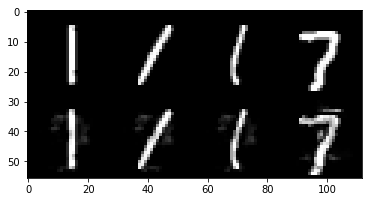

In [12]:
avg_diff = [np.linalg.norm(x.view(-1).data - y.view(-1).data) for x,y in gcs]

def show_im(idx, els=gcs):
    x, y = els[idx]
    x = np.clip(x.view(28, 28).data.numpy(), 0.0, 1.0)
    y = np.clip(y.view(28, 28).data.numpy(), 0.0, 1.0)
    return np.vstack((x, y))


plt.imshow(np.hstack(tuple(show_im(i)  for i in range(4))))

RuntimeError: The size of tensor a (28) must match the size of tensor b (784) at non-singleton dimension 2